# DALLE-Server를 Colab에서 구동하기.

이용하기 쉬운 외부 가상환경인 Colab에서 DALLE-Server를 구동합니다.
Colab 을 상시 서버로 사용하기는 힘들기 때문에 단순히 Test 용도로 쓰는게 좋습니다.

## 필요 파일 설치

서버를 구동하기 위해 필요한 기본 패키지를 Colab 환경에 설치합니다.
의존성 및 안정적인 구동을 고려해 원작자가 추천하는 기본 패키지로 재설치하겠습니다.

In [ ]:
!pip install Flask==1.1.2
!pip install Flask-Cors==3.0.9
!pip install Flask-RESTful==0.3.8
!pip install dalle-pytorch==0.14.3
!pip install tqdm
!pip install deepspeed==0.4.2
!pip install triton==0.4.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 94 kB 3.3 MB/s 
  Attempting uninstall: Flask
    Found existing installation: Flask 1.1.4
    Uninstalling Flask-1.1.4:
      Successfully uninstalled Flask-1.1.4
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 52 kB 1.2 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.4 MB 34.6 MB/s 
     |████████████████████████████████| 1.7 MB 57.2 MB/s 
     |████████████████████████████████| 4.7 MB 53.4 MB/s 
     |████████████████████████████████| 46 kB 4.6 MB/s 
     |████████████████████████████████| 6.6 MB 52.4 MB/s 
     |████████████████████████████████| 53 kB 2.0 MB/s 


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 448 kB 32.9 MB/s 
     |████████████████████████████████| 216 kB 64.9 MB/s 
     |████████████████████████████████| 108 kB 68.5 MB/s 
     |████████████████████████████████| 18.2 MB 28.7 MB/s 
  Created wheel for deepspeed: filename=deepspeed-0.4.2-py3-none-any.whl size=451812 sha256=ad123a79e3f97f2bbc914da49dd0a68bf6a046a76b3e73bdc2310979fc6dd60c
  Stored in directory: /root/.cache/pip/wheels/2e/54/dc/4e03b2864605ed88f84bf963416b066c55cd79a77c6604d6c4
Successfully built deepspeed
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 14.9 MB 16.4 MB/s 
  Attempting uninstall: triton
    Found existing installation: triton 1.1.1
    Uninstalling triton-1.1.1:
      Succ

위 패키지 외에 외부에서 접근 가능하게 만들기 위해 ngrok 패키지가 필요합니다. ngrok 을 사용하면 Flask app 이 Local host 가 아니라 ngrok 에서 만들어주는 특정한 host 에서 실행됩니다.

In [ ]:
!pip install flask-ngrok

## 패키지 임포트

In [ ]:
from flask import Flask, request, jsonify
from flask_ngrok import run_with_ngrok
from tqdm import tqdm
import numpy as np
from queue import Queue, Empty
from threading import Thread
import time

# torch

import torch

from einops import repeat

# vision imports

from PIL import Image

# dalle related classes and utils

from dalle_pytorch import VQGanVAE, DALLE
from dalle_pytorch.tokenizer import tokenizer

import base64
from io import BytesIO

## Flask App 생성

Flask App을 생성하고 초기화합니다.

*참고로 run_with_ngrok 은 ngrok 으로 외부에서 접근하게 하기위한 목적으로 필요합니다.*

In [ ]:
app = Flask(__name__)
run_with_ngrok(app)  # access flask app from outside of colab

requests_queue = Queue()  # request queue.
REQUEST_BATCH_SIZE = 4  # max request size.
CHECK_INTERVAL = 0.1

## Model 불러오기

VQGAN 의 엔코더를 VAE로 불러옵니다.

In [ ]:
# load model

vae = VQGanVAE(None, None)

## Checkpoint download

Pretrained 된 값을 가져오기 위해 Checkpoint를 가져오고, 이를 불러옵니다.
참고로 필요한 Checkpoint는 아래 위치에서 참고했습니다.

- model checkpoint : https://github.com/robvanvolt/DALLE-models/tree/main/models/taming_transformer

In [ ]:
!wget --no-check-certificate https://www.dropbox.com/s/8mmgnromwoilpfm/16L_64HD_8H_512I_128T_cc12m_cc3m_3E.pt

In [ ]:
load_obj = torch.load("./16L_64HD_8H_512I_128T_cc12m_cc3m_3E.pt")
dalle_params, _, weights = load_obj.pop('hparams'), load_obj.pop('vae_params'), load_obj.pop('weights')
dalle_params.pop('vae', None)  # cleanup later

dalle = DALLE(vae=vae, **dalle_params).cuda()
dalle.load_state_dict(weights)
batch_size = 4
top_k = 0.9

## Image 생성

다운로드 받은 Checkpoint에 맞게 Image를 생성합니다.


In [ ]:
def make_images(text_input, num_images):
    try:
        text = tokenizer.tokenize([text_input], dalle.text_seq_len).cuda()

        text = repeat(text, '() n -> b n', b=num_images)

        outputs = []
        for text_chunk in tqdm(text.split(batch_size), desc=f'generating images for - {text}'):
            output = dalle.generate_images(text_chunk, filter_thres=top_k)
            outputs.append(output)

        outputs = torch.cat(outputs)

        response = []

        for i, image in tqdm(enumerate(outputs), desc='saving images'):
            np_image = np.moveaxis(image.cpu().numpy(), 0, -1)
            formatted = (np_image * 255).astype('uint8')

            img = Image.fromarray(formatted)

            buffered = BytesIO()
            img.save(buffered, format="JPEG")
            img_str = base64.b64encode(buffered.getvalue()).decode("utf-8")
            response.append(img_str)

        for i, img_str in enumerate(response):
          print(f'send({i}) => {img_str}')
        return response

    except Exception as e:
        print('Error occur in script generating!', e)
        return jsonify({'Error': e}), 500

def handle_requests_by_batch():
    while True:
        request_batch = []

        while not (len(request_batch) >= REQUEST_BATCH_SIZE):
            try:
                request_batch.append(requests_queue.get(timeout=CHECK_INTERVAL))
            except Empty:
                continue

            for requests in request_batch:
                try:
                    requests["output"] = make_images(requests['input'][0], requests['input'][1])

                except Exception as e:
                    requests["output"] = e


In [ ]:
handler = Thread(target=handle_requests_by_batch)
handler.start()

## Flask 블루 프린트 구성

생성된 Image를 Flask와 REST로 보낼 수 있는 router를 구성합니다.

In [ ]:
@app.route('/generate', methods=['POST'])
def generate():
    if requests_queue.qsize() > REQUEST_BATCH_SIZE:
        return jsonify({'Error': 'Too Many Requests. Please try again later'}), 429

    try:
        args = []
        json_data = request.get_json()
        text_input = json_data["text"]
        num_images = json_data["num_images"]

        if num_images > 10:
            return jsonify({'Error': 'Too many images requested. Request no more than 10'}), 500

        args.append(text_input)
        args.append(num_images)

    except Exception as e:
        return jsonify({'Error': 'Invalid request'}), 500

    req = {'input': args}
    requests_queue.put(req)

    while 'output' not in req:
        time.sleep(CHECK_INTERVAL)

    return jsonify(req['output'])


@app.route('/healthz', methods=["GET"])
def health_check():
    return "Health", 200

## Server 실행

Flask 명령으로 서버를 실행합니다.


In [ ]:
server = Thread(target=app.run)
server.start()

---
## Client 구성

Colab 내 Test 를 위해 Client를 구성합니다. Client로 먼저 주어진 host 주소에 health 체크 명령을 보냅니다.

In [ ]:
import requests

HOST_SERVER = 'http://127.0.0.1:5000'
res = requests.get(HOST_SERVER + '/healthz')
print(res.content)


## Client → Server 요청

Client 를 통해 Image 생성 명령을 보내고, 결과를 받습니다.

- num_images : 생성할 추정 Image 갯수 `(Max=10)`
- text : 컨버팅 해야할 글자

예시의 입력 문자는 'Happy dog' 이지만, 마음대로 바꿔도 됩니다. 

In [ ]:
data = {'num_images': 5, 'text': 'smiling woman'}
res = requests.post('http://127.0.0.1:5000/generate', json=data)

## Client → Server 요청

Client 를 통해 Image 생성 명령을 보내고, 결과를 받습니다.

- num_images : 생성할 추정 Image 갯수 `(Max=10)`
- text : 컨버팅 해야할 글자

예시의 입력 문자는 'Happy dog' 이지만, 마음대로 바꿔도 됩니다. 

In [ ]:
data = {'num_images': 5, 'text': 'smiling woman'}
res = requests.post('http://127.0.0.1:5000/generate', json=data)

generating images for - tensor([[9200, 2308,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0],
        [9200, 2308,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0, 

Using /root/.cache/torch_extensions/py37_cu113 as PyTorch extensions root...
Creating extension directory /root/.cache/torch_extensions/py37_cu113/sparse_attn...
Emitting ninja build file /root/.cache/torch_extensions/py37_cu113/sparse_attn/build.ninja...
Building extension module sparse_attn...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)
Loading extension module sparse_attn...
Time to load sparse_attn op: 20.04456067085266 seconds


/usr/local/lib/python3.7/dist-packages/triton/kernel.py:37: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  return (a + b - 1) // b
/usr/local/lib/python3.7/dist-packages/deepspeed/ops/sparse_attention/matmul.py:44: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  div = sizes // seg_max
generating images for - tensor([[9200, 2308,    0,   

send(0) => /9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCAEAAQADASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwDyuGzl1nWGiizJNPLx9TW3rmm3Pge4t2jula4dcsuM4rY8L3FvpCTa1LEnmoTgnrmuP1O6vvEmpz6lNukLMdq+g9q9GF6NBJx1kr+hNRfvPden5mRsMm+V2+dyWYmiz0+a+n8uJSRnrVmw02fVdQW1hU5JwT6V0

이상없이 서버가 동작하면 아래와 같은 base64 형식의 인코딩 텍스트가 나타납니다.

In [ ]:
print(res.content)

b'["/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCAEAAQADASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwDyuGzl1nWGiizJNPLx9TW3rmm3Pge4t2jula4dcsuM4rY8L3FvpCTa1LEnmoTgnrmuP1O6vvEmpz6lNukLMdq+g9q9GF6NBJx1kr+hNRfvPden5mRsMm+V2+dyWYmiz0+a+n8uJSRnrVmw02fVdQW1hU5JwT6V0N48GgwG

## 디코딩

Base64 로 인코딩된 결과값을 디코딩해서 출력해봅니다.

In [ ]:
img_encodes = res.json()
print(img_encodes)

['/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCAEAAQADASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwDyuGzl1nWGiizJNPLx9TW3rmm3Pge4t2jula4dcsuM4rY8L3FvpCTa1LEnmoTgnrmuP1O6vvEmpz6lNukLMdq+g9q9GF6NBJx1kr+hNRfvPden5mRsMm+V2+dyWYmiz0+a+n8uJSRnrVmw02fVdQW1hU5JwT6V0N48GgwGzt

=> Receive(0) : /9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCAEAAQADASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwDyuGzl1nWGiizJNPLx9TW3rmm3Pge4t2jula4dcsuM4rY8L3FvpCTa1LEnmoTgnrmuP1O6vvEmpz6lNukLMdq+g9q9GF6NBJx1kr+hNRfvPden5mRsMm+V2+dyWYmiz0+a+n8uJSRnrVmw02fVdQW1hU5J

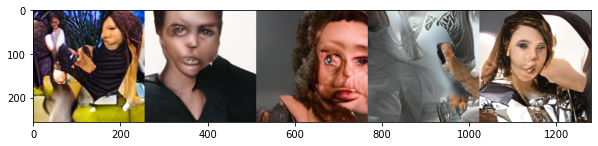

In [ ]:
import matplotlib.pyplot as plt

imgs = []
for i, img_str in enumerate(img_encodes):
  print(f'=> Receive({i}) : {img_str}')
  imgs.append(Image.open(BytesIO(base64.b64decode(img_str))))
imgs = np.concatenate(imgs, axis=1)

plt.figure(figsize=(10, 50))
plt.imshow(imgs)